Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [2]:
NICKNAME = "nazar-si"

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf 

# Часть I. Односторонние разностные схемы

Напишите функцию `deriv`, которая вычисляет производную функции в заданной точке $x$, используя одностороннюю разностную схему с заданным шагом $h$ и степенью аппроксимации $O(h^2)$.

In [3]:
def deriv(f, x, h):
    """ Вычисляет производную `f` в точке `x` с шагом `h`.
    Вычисляет производную, используя односторонню разностную схему со степенью аппроксимации $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        Функция, которую нужно продифференцировать
    x : float
        Точка, в которой нужно дифференцировать функцию
    h : float
        Шаг
        
    Rerurns
    -------
    fder : производная f(x) в точке x с шагом h.
    """
    
    return (-3*f(x)+4*f(x + h)-f(x + 2 * h))/ (2 * h)

#### Тест I.1

Проверьте ваш алгоритм на простом примере: продифференцируйте $f(x) = x^3$ в точке $x=0$. Прокомментируйте, совпадает ли результат с ожидаемым $f'(x) = 0$ при стремлении $h\to 0$.

In [4]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))


0.010000 -- -0.0002
0.001000 --  -2e-06
0.000100 --  -2e-08
0.000010 --  -2e-10


Как и требовалось, степень аппроксимации пропорциональна (в данном случае равна) квадрату шага.

### Тест I.2

Теперь попробуйте немного более сложную функцию $f(x) = x^2 \log{x}$. Оцените значение производной в точке $x=1$, используя *двухточечную* и *трехточечную* схемы. Для обеих схем оцените значение $h$, при котором ошибка перестанет падать.

In [5]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

Минимальная ошибка двухточечного при  6.558884784613714e-09 , на глаз - 1e-8
Минимальная ошибка трехточечного при  1.4284945008956523e-06 , на глаз - 0.4e-5


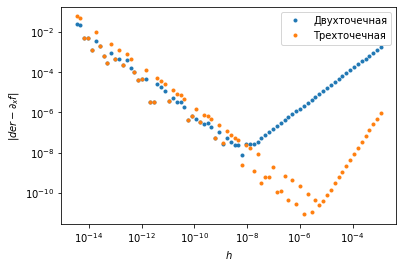

In [6]:
def deriv2(f, x, h):
    return (f(x + h) - f(x)) / h

hs = [1.4 ** (-i) for i in range(20, 100)]

arr1 = []
arr2 = []
for h in hs:
    arr1.append(abs(fder(1) - deriv2(f, 1, h)))
    arr2.append(abs(fder(1) - deriv(f, 1, h)))

plt.loglog(hs, arr1, ".", label="Двухточечная")
plt.loglog(hs, arr2, ".", label="Трехточечная")
plt.legend()
plt.xlabel("$h$")
plt.ylabel("$|der-\partial_x f|$")
plt.plot()

print("Минимальная ошибка двухточечного при ",hs[arr1.index(min(arr1))], ", на глаз - 1e-8")
print("Минимальная ошибка трехточечного при ",hs[arr2.index(min(arr2))], ", на глаз - 0.4e-5")

### Тест I.3 

Теперь продифференцируйте $x^2 \log(x)$ в $x=0$. Используйте трехточечную схему. Заметьте, что в нуле функцию нужно доопределить явным образом. Постройте зависимость ошибки от величины шага $h$. Объясните полученные результаты.



In [7]:
def f(x):
    if x == 0:
        # предел $x^2 log(x)$ при $x-> 0$ равен нулю, хотя log(x) не определен в x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05


Наклон = 1.3862943611198908


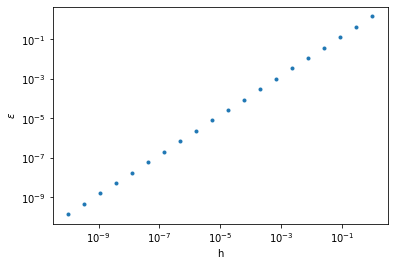

In [8]:
hs = np.logspace(-10, 0, 20)
arr = []
for h in hs:
    arr.append(abs(f(0) - deriv(f, 0, h)))

plt.loglog(hs, arr, ".")
plt.xlabel("h")
plt.ylabel("$\\varepsilon$")
print("Наклон =", (arr[-1] - arr[0]) / (hs[-1] - hs[0]))


$$
\varepsilon = \cfrac{-3f(0) + 4f(h) - f(2h)}{2h} = \cfrac{0 + 4h^2 \ln(h) - 4h^2 \ln(2h)}{2h} = 2h(\ln(h) - \ln(h) - \ln(2)) = 2h\ln(2)
$$

Расчёты, которые мы выполнили после подстановки тоже показывают, что наклон графика равен $2\ln(2)\approx 1.386$

# Часть II. Midpoint rule

Напишите функцию, вычисляющую определенный интеграл, используя midpoint rule, с точностью до заданной погрешности $\epsilon$. Оценивайте ошибку, сравнивая значения интеграла для $N$ и $2N$ элементарных интервалов.

In [19]:
def midpoint_rule(func, a, b, eps):
    """ Вычисляет интеграл f от a до b используя правило центральной точки.
    
    Parameters
    ----------
    func : callable
        Функция, которую нужно проинтегрировать
    a : float
        Нижний предел интегрирования
    b : float
        Верхний предел интегрирования
    eps : float
        Ожидаемая ошибка оценки
        
    Returns
    -------
    integral : float
        Оценка интеграла $\int_a^b f(x) dx$.
    n : int
        The number of intervals on segment.
    """
    def i(f, a, b, n):
        d = (b - a) / n
        return np.sum(np.array([d * f(a + (j + 0.5) * d) for j in range(n)]))

    n = int((b - a) / eps ** 0.5)
    i1 = i(func,a,b,n)
    while True: 
        i2 = i(func,a,b,2 * n)
        if abs(i2 - i1) < eps:
            return i2, n * 2 
        i1 = i2 
        n *= 2


### Тест II.1

Протестирутйте ваш алгоритм на простом интеграле, который вы можете посчитать аналитически.

Сравните скорость сходимости с ожидаемой $O(N^{-2})$ в зависимости от количества интервалов, необходимых для заданной точности $\epsilon$.

Сравните полученный результат с ответом, вычисленным "руками". Попадает ли результат в интервал заданной ошибки?

(20% итоговой оценки)


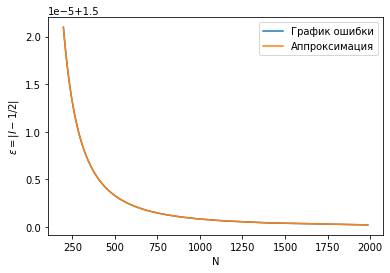

Ошибка аппроксимации 0.00010254067427533388
k = 0.8203086691467626


In [23]:
f = lambda x: np.sin(x) 
res = 1 / 2

eps = [1e-5 * i for i in range(1,100)]
Ns = []
arr = []
for e in eps:
    I, N = midpoint_rule(f, 0, np.pi, e)
    arr.append(abs(I - res))
    Ns.append(N)

plt.plot(Ns, arr, label="График ошибки")
param, error = cf(lambda x,k,x0,c : k / (x-x0) ** 2 + c , Ns, arr)
plt.plot(Ns, param[0] / np.power(np.array(Ns) - param[1], 2) + param[2], label="Аппроксимация")
plt.xlabel("N")
plt.ylabel("$\\varepsilon = |I - 1/2|$")
plt.legend()
plt.show()

print("Ошибка аппроксимации", np.linalg.norm(error))
print("k =", param[0])

В результате работы алгоритма был получен график, который был аппроксимирован кривой
$$
\varepsilon(N) = \cfrac{k}{(N - N_0)^2} + c
$$
И ошибка аппроксимации в данном случае $<1%$, так что полученная зависимость действительно имеет порядок $O(N^{-2})$. 

## Тест II.2

Используя ваш алгоритм, посчитайте значение

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

с точностью до $\epsilon=10^{-4}$.

Заметим, что интеграл содержит интегрируемую особенность в нижнем пределе. Выполните вычисление двумя способами: во первых, посчитайте интеграл "в лоб", во вторых, вычтите особенность из подынтегрального выражения. Сравните количество необходимых итераций для достижения заданной точности $\epsilon$.

(30% итоговой оценки)

In [37]:
res = 1.89216614


eps = 1e-4
N_init = int(1 / eps ** 0.5)
f = lambda x: np.sin(np.sqrt(x)) / x
I, N = midpoint_rule(f, 0, 1, eps)

print("Общее число итераций:", N)
print("Число N/N_init:", "2^", int(np.log2(N / N_init)))
print("Ошибка |Real - I|:", abs(I - res))
err = abs(I - res)

def midpoint_rule_mod(func, b, eps):
    def i(f, a, b, n):
        d = (b - a) / n
        return np.sum(np.array([d * f(a + (j + 0.5) * d) for j in range(n)]))

    n = int(b / eps ** 0.5)
    h = b / (n ** 2 + 2)
    i1 = i(func,h,b,n)
    while True: 
        i2 = i(func,h,b,2 * n)
        if abs(i2 - i1) < eps:
            return i2, n * 2 
        i1 = i2 
        n *= 2

N_init = int(1 / eps ** 0.5)
I, N_p = midpoint_rule_mod(f, 1, eps)

print("Улучшенное число итераций:", N)
print("Улучшенное число N'/N_init:", "2^", int(np.log2(N_p / N_init)))
print("Новая ошибка |Real - I'|:", abs(I - res))
print("Выигрыш в итерациях Err'/Err:", int(np.log2(N / N_p)))
print("Проигрыш в ошибке Err'/Err:", abs(I - res)/err)

Общее число итераций: 6553600
Число N/N_init: 2^ 16
Ошибка |Real - I|: 0.0002362877988233425
Улучшенное число итераций: 6553600
Улучшенное число N'/N_init: 2^ 8
Новая ошибка |Real - I'|: 0.020029180396078372
Выигрыш в итерациях Err'/Err: 8
Проигрыш в ошибке Err'/Err: 84.7660374163159


# Часть  III 


Вычислите определённый интеграл **методом трапеций**  с вычитанием сингулярности

$$
I = \int_{0}^{1}\frac{e^x}{\sqrt{x(1-x)}}dx.
$$

Преобразуйте данный интеграл, вычитая сингулярности. Выпишите расчетные формулы.

Вам могут пригодиться значения следующих определенных интегралов:

$$
\int_0^1 \frac{1}{\sqrt{x (1-x)}} \, dx=\pi,\quad \int_0^1 \frac{x}{\sqrt{x (1-x)}} \, dx=\pi/2.
$$

YOUR ANSWER HERE

Cоставьте функцию, возвращающую значение интеграла методом трапеций.

In [12]:
def integ(npts=10):
    """Compute the value of the integral above.
    
    Subtract the singularities and use the trapezoid rule. 
    
    Parameters
    ----------
    npts : int
        The number of points for the trapezoid rule
        
    Returns
    -------
    I : float
       The computed value of the integral
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [13]:
# this is a test to check your computed value
from numpy.testing import assert_allclose
